In [1]:
# сколько матчей провел в команде игрок
# какая это игра по счету в турнире(можно попробовать нормализовать)
#

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Пропуски в данных

In [4]:
data.columns[data.isnull().any()].tolist()

['ADR p_0',
 'ADR p_1',
 'ADR p_2',
 'ADR p_3',
 'ADR p_4',
 'ADR p_5',
 'ADR p_6',
 'ADR p_7',
 'ADR p_8',
 'ADR p_9',
 'K/D p_0',
 'K/D p_1',
 'K/D p_2',
 'Most damage',
 'Most damage player']

In [5]:
problem_columns = data[['K/D p_0', 'K/D p_1', 'K/D p_2', 'match page']]
problem_columns[problem_columns.isnull().any(axis=1)]

,K/D p_0,K/D p_1,K/D p_2,match page
1548,4.6,8.50,NaN,/?pageid=188&matchid=44656
4723,NaN,23.00,1.86,/?pageid=188&matchid=40753
14200,NaN,3.00,3.40,/?pageid=188&matchid=29248
23305,NaN,3.33,2.50,/?pageid=188&matchid=19195
25021,NaN,4.00,1.27,/?pageid=188&matchid=17229
25216,4.5,NaN,3.75,/?pageid=188&matchid=17025


# Data Preparation

In [6]:
matches_stats = pd.DataFrame(index=data.index)

In [7]:
for col in data.columns:
    print(col)

A p_0
A p_1
A p_2
A p_3
A p_4
A p_5
A p_6
A p_7
A p_8
A p_9
ADR p_0
ADR p_1
ADR p_2
ADR p_3
ADR p_4
ADR p_5
ADR p_6
ADR p_7
ADR p_8
ADR p_9
Best rating
Best rating player
Clutches won
D p_0
D p_1
D p_2
D p_3
D p_4
D p_5
D p_6
D p_7
D p_8
D p_9
Event
FK Diff p_0
FK Diff p_1
FK Diff p_2
FK Diff p_3
FK Diff p_4
FK Diff p_5
FK Diff p_6
FK Diff p_7
FK Diff p_8
FK Diff p_9
First kills
Game score
K (HS) p_0
K (HS) p_1
K (HS) p_2
K (HS) p_3
K (HS) p_4
K (HS) p_5
K (HS) p_6
K (HS) p_7
K (HS) p_8
K (HS) p_9
K/D Diff p_0
K/D Diff p_1
K/D Diff p_2
K/D Diff p_3
K/D Diff p_4
K/D Diff p_5
K/D Diff p_6
K/D Diff p_7
K/D Diff p_8
K/D Diff p_9
K/D p_0
K/D p_1
K/D p_2
K/D p_3
K/D p_4
K/D p_5
K/D p_6
K/D p_7
K/D p_8
K/D p_9
Map
More info
Most AWP kills
Most AWP kills player
Most Kills
Most Kills player
Most assists
Most assists player
Most damage
Most damage player
Most first kills
Most first kills player
Played
Rating p_0
Rating p_1
Rating p_2
Rating p_3
Rating p_4
Rating p_5
Rating p_6
Rating p_7
Rating 

## A(assists)

In [8]:
for i in range(10):
    matches_stats['assists_p{}'.format(i)] = data['A p_{}'.format(i)]

## ADR (Average Damage Rating)

In [9]:
for i in range(10):
    matches_stats['adr_p{}'.format(i)] = data['ADR p_{}'.format(i)]

## Clutches won

In [10]:
def parse_clutches(x):
    cw_t1, cw_t2 = x.replace(' ', '').split(':')
    return float(cw_t1), float(cw_t2)
    
clutches = data['Clutches won'].apply(parse_clutches)
matches_stats['clutches_t1'], matches_stats['clutches_t2'] = zip(*clutches)

## D (deaths)

In [11]:
for i in range(10):
    matches_stats['deaths_p{}'.format(i)] = data['D p_{}'.format(i)]

## Event

In [12]:
matches_stats['event_id'] = data['Event'].apply(lambda s: float(s.split('=')[-1]))

## FK Diff

In [13]:
for i in range(10):
    matches_stats['fk_diff_p{}'.format(i)] = data['FK Diff p_{}'.format(i)]

## FK(teams first kills)

In [14]:
def parse_first_kills(x):
    fk_t1, fk_t2 = x.split(':')
    return float(fk_t1), float(fk_t2)
    
first_kills = data['First kills'].apply(parse_first_kills)
matches_stats['firstkills_t1'], matches_stats['firstkills_t2'] = zip(*first_kills)

## Game score

In [15]:
def parse_score(x):
    try:
        scores = x.replace('(', '').replace(')', '')
        scores = [s.split(':') for s in scores.split()]
        scores = [(float(s[0]), float(s[1])) for s in scores]
        if len(scores) == 3:
            scores.append((0., 0.))
    except:
        print(x)
        
    return [x for s in scores for x in s]

data.iloc[19684, data.columns.get_loc('Game score')] = '7:16 (5:10) (2:6)'
data.iloc[19686, data.columns.get_loc('Game score')] = '16:13 (11:4) (5:9)'

(matches_stats['score_t1'], matches_stats['score_t2'], 
 matches_stats['score_fh_t1'], matches_stats['score_fh_t2'], 
 matches_stats['score_sh_t1'], matches_stats['score_sh_t2'], 
 matches_stats['score_er_t1'], matches_stats['score_er_t2']) = zip(*data['Game score'].apply(parse_score))

## K (HS) - kills and headshots

In [16]:
def parse_kills_and_hs(x):
    x = x.replace('(', '').replace(')', '')
    kills, hs = x.split()
    return float(kills), float(hs)

for i in range(10):
    kills_and_hs = data['K (HS) p_{}'.format(i)].apply(parse_kills_and_hs)
    matches_stats['kills_p{}'.format(i)], matches_stats['headshots_p{}'.format(i)] = zip(*kills_and_hs)

## Map

In [17]:
matches_stats['Map'] = data['Map'].apply(lambda s: re.sub(r'_.*$', '', s))

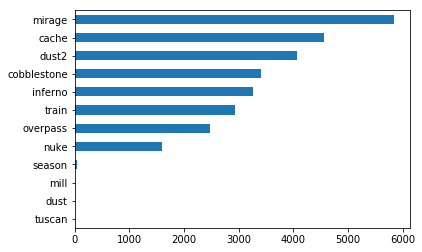

In [18]:
maps_counts = matches_stats['Map'].value_counts()
maps_counts = maps_counts.sort_values()
maps_counts.plot(kind='barh')
plt.show()

## Played

In [19]:
matches_stats['time'] = data['Played']

## Rating

In [20]:
for i in range(10):
    matches_stats['rating_p{}'.format(i)] = data['Rating p_{}'.format(i)]

## Raw stats - player id

In [21]:
for i in range(10):
    matches_stats['p{}_id'.format(i)] = data['Raw stats p_{}'.format(i)].apply(lambda s: int(s.split('=')[-1]))

## Team - teams ids

In [22]:
matches_stats['t1_id'] = data['team one'].apply(lambda s: int(s.split('=')[-1]))
matches_stats['t2_id'] = data['team two'].apply(lambda s: int(s.split('=')[-1]))

# Сохранить результаты

In [23]:
matches_stats.to_csv('data_prepared.csv', index=False)